### Importing Required Libraries

In [26]:
pip install pmdarima

In [27]:
#Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [34]:
holidays = pd.read_csv('/content/holidays_events.csv',parse_dates=['date'])
oil = pd.read_csv('/content/oil.csv',parse_dates=['date'])
stores = pd.read_csv('/content/stores.csv')
transactions = pd.read_csv('/content/transactions.csv',parse_dates=['date'])

In [35]:
train = pd.read_csv('/content/train.csv',parse_dates=['date'])
test = pd.read_csv('/content/test.csv',parse_dates=['date'])

In [36]:
def select_sample(df, n=10000):
    if df is not None and len(df) > n:
        return df.sample(n=n, random_state=42)  # Random sample of 10,000 rows
    return df

oil = select_sample(oil, 100000)
holidays = select_sample(holidays, 100000)
stores = select_sample(stores, 100000)
train_sampled = select_sample(train, 100000)
transactions = select_sample(transactions, 100000)
test = select_sample(test, 100000)


In [37]:
# Rename 'type' to 'holiday_type' in holidays
holidays = holidays.rename(columns={'type': 'holiday_type'})

# Feature Engineering - Create date-related features
for data in [oil, holidays, train, transactions, test]:
    if 'date' in data.columns:
        data['year'] = data['date'].dt.year
        data['month'] = data['date'].dt.month
        data['day'] = data['date'].dt.day
        data['day_of_week'] = data['date'].dt.dayofweek
        data['day_name'] = data['date'].dt.strftime('%A')


In [38]:
# Merge datasets (train and test separately)
train = train.merge(oil[['date', 'dcoilwtico']], on='date', how='left')
train = train.merge(holidays, on=['date', 'day', 'month', 'year', 'day_of_week', 'day_name'], how='left')
train = train.merge(stores.rename(columns={'type': 'store_type'}), on='store_nbr', how='left')
train = train.merge(transactions, on=['date', 'store_nbr', 'day', 'month', 'year', 'day_of_week', 'day_name'], how='left')

test = test.merge(oil[['date', 'dcoilwtico']], on='date', how='left')
test = test.merge(holidays, on=['date', 'day', 'month', 'year', 'day_of_week', 'day_name'], how='left')
test = test.merge(stores.rename(columns={'type': 'store_type'}), on='store_nbr', how='left')
test = test.merge(transactions, on=['date', 'store_nbr', 'day', 'month', 'year', 'day_of_week', 'day_name'], how='left')

In [39]:
train_grouped = train.groupby(['store_nbr', 'family', 'date']).agg({'sales': 'sum'}).reset_index()

In [40]:
# Fill missing values (e.g., using forward fill)
train['dcoilwtico'].fillna(method='ffill', inplace=True)
train['transactions'].fillna(method='ffill', inplace=True)


In [42]:
# 4. Create Time Series for Each Group:
store_family_sales = {}
for store in train_grouped['store_nbr'].unique():
    for family in train_grouped['family'].unique():
        data = train_grouped[(train_grouped['store_nbr'] == store) & (train_grouped['family'] == family)]
        data = data.set_index('date')['sales']
        store_family_sales[(store, family)] = data

In [ ]:
# Step 1: Split the data into training and testing sets based on time
# We'll use the last 30 days for testing
split_date = data_agg.index.max() - pd.Timedelta(days=30)
train_data = data_agg[data_agg.index <= split_date]
test_data = data_agg[data_agg.index > split_date]

print(f"Training data from {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing data from {test_data.index.min()} to {test_data.index.max()}")

# Step 2: Define the target variable and exogenous variables
y_train = train_data['sales']
X_train = train_data.drop(columns=['sales'])

y_test = test_data['sales']
X_test = test_data.drop(columns=['sales'])

from statsmodels.tsa.stattools import adfuller
result = adfuller(data_agg['sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


Training data from 2013-01-01 00:00:00 to 2017-07-16 00:00:00
Testing data from 2017-07-17 00:00:00 to 2017-08-15 00:00:00
ADF Statistic: -2.907948709051487
p-value: 0.04443144796327471


In [ ]:
# Step 3: Automatically determine the optimal SARIMA parameters
# Note: auto_arima can take time depending on data size
stepwise_model = auto_arima(
    y_train,
    exogenous=X_train,
    seasonal=True,
    m=7,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)


print("\nSARIMA Model Summary:")
print(stepwise_model.summary())

# Step 4: Make predictions on the test set
forecast = stepwise_model.predict(n_periods=len(test_data), exogenous=X_test)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=44886.475, Time=6.73 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=45751.209, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=45465.870, Time=0.52 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=45255.910, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=45749.222, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=45065.204, Time=6.60 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=45012.227, Time=2.92 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=44886.863, Time=11.99 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=44887.990, Time=9.55 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=45138.326, Time=4.61 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=45011.366, Time=6.06 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=44946.429, Time=7.48 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=44869.053, Time=18.85 sec
 ARIMA(1,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=13.44 sec
 ARIMA(2,1,1)(2,0,2)[7


Model Evaluation Metrics:
Mean Squared Error (MSE): 8950167612.86
Root Mean Squared Error (RMSE): 94605.33
Mean Absolute Error (MAE): 64006.27
R-squared (R²): 0.41


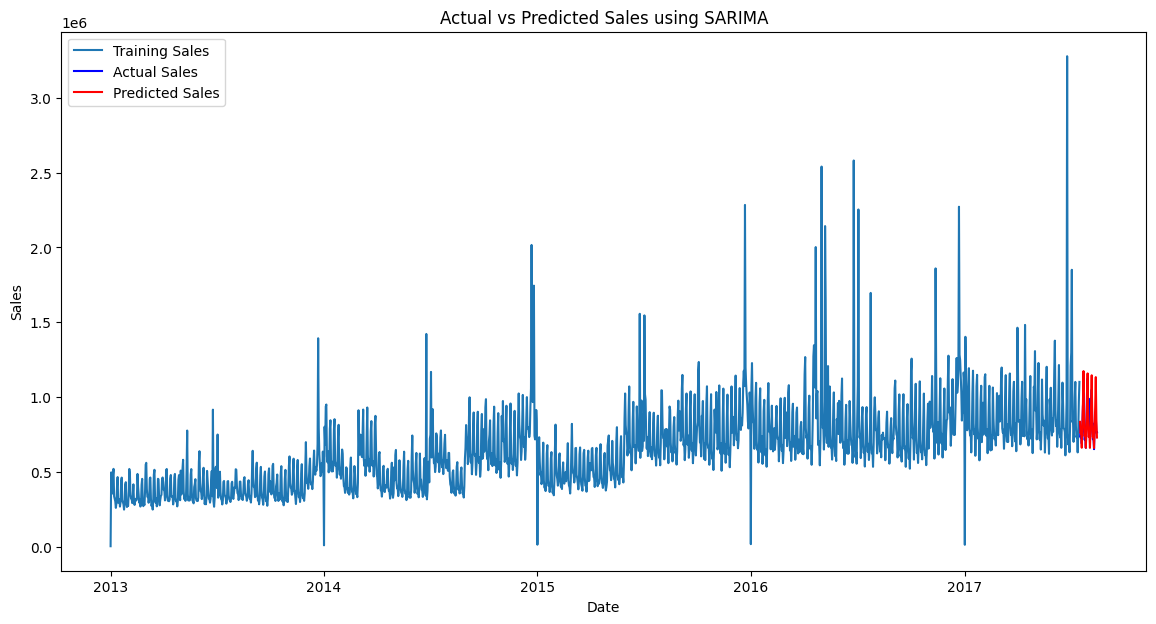

In [ ]:
# Step 5: Evaluate the model
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, forecast)
r2 = r2_score(y_test, forecast)

print(f"\nModel Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Step 6: Plot Actual vs Predicted Sales
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, y_train, label='Training Sales')
plt.plot(test_data.index, y_test, label='Actual Sales', color='blue')
plt.plot(test_data.index, forecast, label='Predicted Sales', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales using SARIMA')
plt.legend()
plt.show()